In [1]:
# huggingface libraries 
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, XLMRobertaConfig
from transformers import RobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TFAutoModel, AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_model, LoraConfig, TaskType

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset, TensorDataset

# additional libraries
from tqdm import tqdm 
import pandas as pd
import numpy as np
import os
import gc
import random
import time

#viz
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Set the logging level to error to suppress warnings (and info messages)
from transformers import logging
logging.set_verbosity_error()

print(torch.__version__)

2.3.0+cu121


In [18]:
# Huggingface authetication for model download

#from huggingface_hub import login
#login()

#### **Initiate cuda**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device type:', device)
print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('GPU is:', torch.cuda.get_device_name(0))

Device type: cuda
There are 1 GPU(s) available.
GPU is: NVIDIA GeForce RTX 4050 Laptop GPU


##### **Load NLI dataset into dataframe**

In [3]:
dataset = pd.read_csv('/home/ssever/contradiction-detection/data/csv_files/nli_data_set.csv')

#dataset = dataset[dataset.label_string != 'worldknowledge']

#### **Transform dataset to 3 labels (Use only for 3-label classification!)**

In [6]:
replacement_map = {
    "antonymity": "contradiction",
    "factive_antonymity": "contradiction",
    "factive_embedding_verb": "contradiction",
    "lexical": "contradiction",
    "negation": "contradiction",
    "numeric": "contradiction",
    "structure": "contradiction",
    "temporal": "contradiction",
    "worldknowledge": "contradiction"
}

# Replace all labels except 'neutral' and 'entailment' with 'contradiction'
dataset['label_string'] = dataset['label_string'].replace(replacement_map)

In [5]:
# Identify unique words and sort them to maintain consistency
unique_words = sorted(dataset['label_string'].unique())

# Create a mapping from words to digits
word_to_digit = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

# Apply the mapping to the 'label' column
dataset['label'] = dataset['label_string'].map(word_to_digit)

#### **Create holdout test set**

In [4]:
data, test = train_test_split(dataset, stratify=dataset.label.values, 
                                                  random_state=42, # note that holdout test set distribution is permanently set
                                                  test_size=0.1, shuffle=True)

data.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# check the number of rows and columns after split
print("Data size: {} \n".format(data.shape))
print("Test size: {}".format(test.shape))

Data size: (3097, 5) 

Test size: (345, 5)


#### **Create train and validation data sets**

In [5]:
train, val = train_test_split(data, stratify=data.label.values, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

# check the number of rows and columns after split
print("Train size: {} \n".format(train.shape))
print("Validation size: {}".format(val.shape))

Train size: (2787, 5) 

Validation size: (310, 5)


#### **Check number of classes again**

In [6]:
# Check for number of unique labels
dataset['label_string'].nunique()

11

### **Training the model**

In [7]:
# Set seed (function called down under training)
def seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)
    else:
        torch.manual_seed(seed_val)

# Choose a model
#model_name ='bert-base-cased'
#model_name ='bert-large-cased'
model_name ='roberta-base'
#model_name ='roberta-large'
#model_name ='xlm-roberta-base'
#model_name = 'xlm-roberta-large'
#model_name = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'
#model_name = 'joeddav/xlm-roberta-large-xnli'

# Initialize tokenizer
if model_name == 'joeddav/xlm-roberta-large-xnli':
    tokenizer = AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli', use_fast=False)
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name)


# Function for encoding input data
def encode_sets(data, tokenizer):
    kwargs = { 'truncation': True,
    'max_length': MAX_LENGTH,
    'padding': 'max_length',
    'return_attention_mask': True, 
    'return_token_type_ids': True     
    }
    datalist = list(zip(data['premise'], data['hypothesis']))
    tokenized = tokenizer.batch_encode_plus(datalist,**kwargs)
    input_ids = torch.LongTensor(tokenized.input_ids)
    attention_masks = torch.LongTensor(tokenized.attention_mask)
    token_type_ids = torch.LongTensor(tokenized.token_type_ids)
    return input_ids, attention_masks, token_type_ids

# Get number of labels in dataset
num_classes = dataset['label'].nunique()

# label names according to 3 label or 11 label dataset
if num_classes == 3:
    label_names = [
    "entailment",
    "neutral",
    "contradiction"
] 
elif num_classes == 11:
    label_names = [
        "antonymity",
        "entailment",
        "factive_antonymity",
        "factive_embedding_verb",
        "lexical",
        "negation",
        "neutral",
        "numeric",
        "structure",
        "temporal",
        "worldknowledge"
    ]

# Create class weights for weighted loss
class_counts = []

for name in label_names:
    class_counts.append(val['label_string'].value_counts()[name])

total_counts = sum(class_counts)
weights = [total_counts / class_count for class_count in class_counts]
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)

# Set cross-entropy loss as loss function
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)

epochs_list = []

# Set arrays for loss and prediction results
train_loss = []
val_loss = []
test_loss = []

val_preds = []
true_classes = []
accuracies = []

test_preds = []
test_true_classes = []
test_accuracies = []

learning_rate = []
batch_size = []

# Number of searches
n_searches = 1

#BATCH_SIZE = [16]
#L_RATE = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6]

for search in range(n_searches):
    
    # Set seed for reproducibility
    seed(1024)

    train_loss_search = []
    val_loss_search = []
    test_loss_search = []

    val_preds_search = []
    true_classes_search = []
    accuracies_search = []

    test_preds_search = []
    test_true_classes_search = []
    test_accuracies_search = []

    # Hyperparameter settings
    #BATCH_SIZE = random.choice([8, 16, 32, 64])
    BATCH_SIZE = 16
    #L_RATE = 10 ** random.uniform(-5, -6)
    L_RATE = 5.5e-06
    #L_RATE = 1e-05
    MAX_LENGTH = 256
    NUM_EPOCHS = 80

    # Encode train set
    input_ids, attention_masks, token_type_ids = encode_sets(train, tokenizer)
    labels = torch.Tensor(train['label']).reshape(-1, 1)
    train_tensor = TensorDataset(input_ids, attention_masks, token_type_ids, labels)
    train_dataloader = DataLoader(train_tensor, sampler=RandomSampler(train_tensor), batch_size=BATCH_SIZE)

    # Encode validation set
    input_ids, attention_masks, token_type_ids = encode_sets(val,tokenizer)
    labels = torch.Tensor(val['label']).reshape(-1, 1)
    val_tensor = TensorDataset(input_ids, attention_masks, token_type_ids, labels)
    val_dataloader = DataLoader(val_tensor, sampler=SequentialSampler(val_tensor), batch_size=BATCH_SIZE)

    # Early stopping settings
    patience = 10
    best_loss = float('inf')
    patience_counter = 0
    #stop_epochs = 0

    # Initialize model
    if model_name == "bert-base-cased" or model_name == 'bert-large-cased':
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes, output_hidden_states=False, output_attentions=False, problem_type="multi_label_classification")
    elif model_name == "roberta-base" or model_name == 'roberta-large':
        model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
    elif model_name == "xlm-roberta-base" or model_name == 'xlm-roberta-large' or ((model_name == 'symanto/xlm-roberta-base-snli-mnli-anli-xnli' or model_name == 'joeddav/xlm-roberta-large-xnli') and num_classes == 3):
        model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
    elif (model_name == 'symanto/xlm-roberta-base-snli-mnli-anli-xnli' or model_name == 'joeddav/xlm-roberta-large-xnli') and num_classes == 11:
        config = XLMRobertaConfig.from_pretrained(model_name, num_labels=num_classes)
        model = XLMRobertaForSequenceClassification(config)
        
    """
    # Define LoRA configuration
    r = 16
    lora_alpha = r*2
    
    peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=r,            # Rank of the low-rank matrices
    lora_alpha=lora_alpha,  # Scaling factor
    lora_dropout=0.1,  # Dropout rate
    target_modules=["query", "key", "value"]  # Apply LoRA only to attention matrices
)

    # Apply LoRA configuration to model
    model = get_peft_model(model, peft_config)
    """
    
    # Move model to device (GPU)
    model.to(device)
    
    # Print model and training details

    print(f"\nNumber of classes: {num_classes}")
    print(f"\nModel: {model_name}\n")
    #model.print_trainable_parameters()
    print(f"\nLearning Rate = {L_RATE} Batch Size = {BATCH_SIZE}\n")
    print(f"Number of batches in train set: {len(train_dataloader)}")
    print(f"Number of batches in validation set: {len(val_dataloader)}\n")

    # Load optimizer
    optimizer = AdamW(model.parameters(),
                lr = L_RATE, 
                eps = 1e-8
                )
    
    """ # Create scheduler
    total_steps = len(train_dataloader) * NUM_EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0.1 * len(train_dataloader),
                                                num_training_steps = total_steps)"""

    total_start_time = time.time()
    
    for epoch in range(NUM_EPOCHS):

        # Training:

        model.train()
        torch.set_grad_enabled(True)
        total_train_loss=0
            
        for i,batch in tqdm(enumerate(train_dataloader)):
            # clear previous gradients
            optimizer.zero_grad()
            
            input_ids, attention_masks, token_type_ids = (batch[0].to(device), 
                                                          batch[1].to(device),
                                                          batch[2].to(device))
            
            outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks)

            #loss=outputs[0]
            labels = torch.nn.functional.one_hot(batch[3].to(torch.int64), num_classes=num_classes).squeeze(1).float().to(device)
            #labels = torch.argmax(batch[3], dim=1).to(device)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_train_loss += loss.item()

            # Backpropagation:
            
            # calculate gradients
            loss.backward()
            # clip the norm of the gradients to 1.0. (prevents gradient explosion)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # parameter update
            optimizer.step()
            
            # Scheduler update
            #scheduler.step()

        # Validation:
        
        model.eval()

        #torch.set_grad_enabled(False)
        total_val_loss = 0

        for j, batch in enumerate(val_dataloader):
            
            with torch.no_grad():
                input_ids, attention_masks, token_type_ids = (batch[0].to(device), 
                                                              batch[1].to(device),
                                                              batch[2].to(device))
                
                start_time = time.time()
                outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks)
                end_time = time.time()

            #loss = outputs[0]
            logits = outputs.logits
            labels = torch.nn.functional.one_hot(batch[3].to(torch.int64), num_classes=num_classes).squeeze(1).float().to(device)
            #labels = torch.argmax(batch[3], dim=1).to(device)
            loss = criterion(logits, labels)
            true = batch[3]

            model_preds = logits.detach().cpu().numpy()
            total_val_loss += loss.item()
            #stop_loss = total_val_loss / len(val_dataloader)

            if j == 0:  # first batch
                stacked_model_preds = model_preds
                true_labels = true
            else:
                stacked_model_preds = np.vstack((stacked_model_preds, model_preds))
                true_labels = np.vstack((true_labels, true))
    
        # Train loss results per epoch
        #print(f'Training loss on epoch {epoch + 1}: {total_train_loss}')
        train_loss_search.append(total_train_loss)

        # Validation loss results per epoch
        #print(f'\n------------------------------------\nValidation loss on epoch {epoch + 1}: {total_val_loss}\n------------------------------------\n')

        val_preds_search.append(np.argmax(stacked_model_preds, axis=1))
        true_classes_search.append(true_labels.flatten().astype('int64'))
        accuracies_search.append(np.sum(val_preds_search[epoch] == true_classes_search[epoch])/len(val_preds_search[epoch]))
        val_loss_search.append(total_val_loss)
        """
        # Testing:

        # Encode test set
        input_ids, attention_masks, token_type_ids = encode_sets(test,tokenizer)
        labels = torch.Tensor(test['label']).reshape(-1, 1)
        test_tensor = TensorDataset(input_ids, attention_masks, token_type_ids, labels)
        test_dataloader = DataLoader(test_tensor, sampler=SequentialSampler(test_tensor), batch_size=BATCH_SIZE)

        model.eval()

        total_test_loss = 0

        for j, batch in enumerate(test_dataloader):
            
            with torch.no_grad():
                input_ids, attention_masks, token_type_ids = (batch[0].to(device), 
                                                                batch[1].to(device),
                                                                batch[2].to(device))
                
                start_time = time.time()
                outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks)
                end_time = time.time()

            logits = outputs.logits
            # Predicted labels
            labels = torch.nn.functional.one_hot(batch[3].to(torch.int64), num_classes=num_classes).squeeze(1).float().to(device)
            loss = criterion(logits, labels)
            # True labels
            test_true = batch[3]

            model_preds = logits.detach().cpu().numpy()
            total_test_loss += loss.item()

            if j == 0:  # first batch
                stacked_test_preds = model_preds
                true_labels = test_true
            else:
                stacked_test_preds = np.vstack((stacked_test_preds, model_preds))
                true_labels = np.vstack((true_labels, test_true))

        test_preds_search.append(np.argmax(stacked_test_preds, axis=1))
        test_true_classes_search.append(true_labels.flatten().astype('int64'))
        test_accuracies_search.append(np.sum(test_preds_search[epoch] == test_true_classes_search[epoch])/len(test_preds_search[epoch]))
        test_loss_search.append(total_test_loss)
"""
        # Early stopping
        if total_val_loss < best_loss:
            best_loss = total_val_loss
            patience_counter = 0
            # Saving model
            #torch.save(model, f"roberta-base.pt")
        else:
            patience_counter += 1

        if patience_counter == patience:
            # Calculate inference time
            inference_time = end_time - start_time
            print(f"\nInference time: {inference_time:.4f} seconds\n")

            print(f"Early stopping triggered at epoch {epoch+1}!")
            break
        
    total_end_time = time.time()
    print(f"\nTotal time for training: {(total_end_time - total_start_time)/60:.2f} minutes")
    

    learning_rate.append(L_RATE)
    batch_size.append(BATCH_SIZE)
    epochs_list.append(epoch)
    train_loss.append(train_loss_search)
    val_loss.append(val_loss_search)
    test_loss.append(test_loss_search)

    val_preds.append(val_preds_search)
    true_classes.append(true_classes_search)
    accuracies.append(accuracies_search)
    """
    test_preds.append(test_preds_search)
    test_true_classes.append(test_true_classes_search)
    test_accuracies.append(test_accuracies_search)
    """
    # Clear memory
    del model
    del optimizer
    #del scheduler
    del train_tensor
    del val_tensor
    del train_dataloader
    del val_dataloader
    torch.cuda.empty_cache()
    gc.collect()


Number of classes: 11

Model: roberta-base


Learning Rate = 5.5e-06 Batch Size = 16

Number of batches in train set: 175
Number of batches in validation set: 20



175it [01:35,  1.83it/s]
175it [01:39,  1.76it/s]
175it [01:42,  1.70it/s]
175it [01:42,  1.70it/s]
175it [01:42,  1.70it/s]
175it [01:45,  1.67it/s]
175it [01:44,  1.68it/s]
175it [01:44,  1.68it/s]
175it [01:44,  1.68it/s]
175it [01:44,  1.68it/s]
175it [01:44,  1.68it/s]
175it [01:43,  1.68it/s]
175it [01:43,  1.68it/s]
175it [01:46,  1.64it/s]
175it [01:47,  1.63it/s]
175it [01:45,  1.66it/s]
175it [01:45,  1.66it/s]
175it [01:45,  1.66it/s]



Inference time: 0.0075 seconds

Early stopping triggered at epoch 18!

Total time for training: 32.17 minutes


### **Validation**

#### **Loss graph**

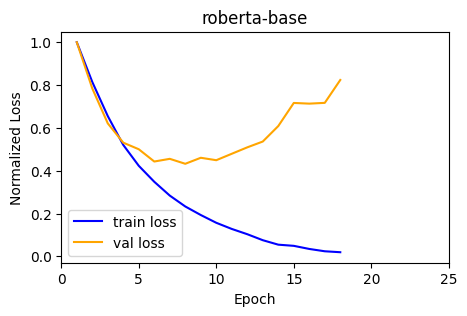

In [9]:
import matplotlib.pyplot as plt


for e in range(0, len(epochs_list)):

    epochs = list(range(1, epochs_list[e]+2))

    # Normalize losses for visualization
    max_train_loss = max(train_loss[e])
    training_loss_normalized = [loss / max_train_loss for loss in train_loss[e]]
    max_val_loss = max(val_loss[e])
    val_loss_normalized = [loss / max_val_loss for loss in val_loss[e]]

    # Create the plot
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, training_loss_normalized, label='train loss', color='blue')
    plt.plot(epochs, val_loss_normalized, label='val loss', color='orange')
    plt.xlabel('Epoch')
    plt.xticks(np.linspace(0, 25, 6, endpoint=True))
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # Format x-axis tick labels to display as integers
    from matplotlib.ticker import FormatStrFormatter
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
    plt.ylabel('Normalized Loss')
    #plt.ylim(0.9, 1.0)
    #plt.title(f'Search: {e+1} LR: {learning_rate[e]} BS: {batch_size[e]}')
    plt.title(model_name)
    plt.legend()
    plt.show()

#### **Results of epoch with smallest test loss**

In [10]:
# Smallest test loss

index_list = []

for v in range(len(val_loss)):
    lowest = min(val_loss[v])
    index_lowest = val_loss[v].index(lowest)
    acc = accuracies[v][index_lowest]
    index_list.append(index_lowest)
    acc_max = accuracies[v].index(max(accuracies[v]))
    print(f"Search {v+1} | Total epochs: {epochs_list[v]+1} | Best epoch: {index_lowest + 1} with loss: {lowest} and accuracy of {round(acc,4)*100}% | LR: {learning_rate[v]} | BS: {batch_size[v]}")
    print(f"Highest accuracy: {round(max(accuracies[v]),4)*100}% at epoch {acc_max + 1}\n")

Search 1 | Total epochs: 18 | Best epoch: 8 with loss: 191.51887118816376 and accuracy of 80.65% | LR: 5.5e-06 | BS: 16
Highest accuracy: 82.89999999999999% at epoch 18



#### **Classification reports**

In [15]:
# Create classification reports

# label names according to 3 label or 11 label dataset
if num_classes == 3:
    target_names = [
    "entailment",
    "neutral",
    "contradiction"
] 
elif num_classes == 11:
    target_names = [
        "antonymity",
        "entailment",
        "factive_antonymity",
        "factive_embedding_verb",
        "lexical",
        "negation",
        "neutral",
        "numeric",
        "structure",
        "temporal",
        "worldknowledge"
    ]

classification_reports = []

filename= "cr_reports.txt"

with open(filename, "w") as file:
    for e in range(len(epochs_list)):
        for epoch in range(epochs_list[e]):
            cr = classification_report(true_classes[e][epoch], 
                                val_preds[e][epoch],
                                target_names=target_names, 
                                digits=4)
            classification_reports.append(cr)

            file.write(f"Report of Search {e+1} for Epoch {epoch + 1}:\n\n{cr}\n")
            file.write("-----End of Report-----\n\n")
        file.write("-----End of Search-----\n\n")

In [ ]:
# Get classification report of epoch with lowest loss

filename= "cr_reports.txt"

with open(filename, "r") as file:
    content = file.read()

searches = content.split("-----End of Search-----\n\n")

searches = [search for search in searches if search]

reports = []

for search in searches:
    report = search.split("-----End of Report-----\n\n")
    reports.append(report)

reports = [report for report in reports if report]

i = 0
step = 0

for report in reports:
    if step != 0:
        i += 1
    for r in report:
        if report.index(r) == index_list[i]:
            print(r)
            step = 1

#### **Confusion matrix**

In [ ]:
# Create confusion matrix

# label names according to 3 label or 11 label dataset
if num_classes == 3:
    target_names = [
    "entailment",
    "neutral",
    "contradiction"
] 
elif num_classes == 11:
    target_names = [
        "antonymity",
        "entailment",
        "factive_antonymity",
        "factive_embedding_verb",
        "lexical",
        "negation",
        "neutral",
        "numeric",
        "structure",
        "temporal",
        "worldknowledge"
    ]

cm = confusion_matrix(true_classes[0][index_lowest], val_preds[0][index_lowest])

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix Val')
plt.show()

### **Testing**

In [ ]:
acc = test_accuracies[0][12]
print(f"accuracy of {round(acc,4)*100}%")

In [ ]:
# Smallest test loss

index_list = []

for v in range(len(val_loss)):
    #lowest = min(val_loss[v])
    #index_lowest = test_loss[v][13]
    acc = test_accuracies[v][12]
    print(f"accuracy of {round(acc,4)*100}%")
    #index_list.append(index_lowest)
    #acc_max = test_accuracies[v].index(max(test_accuracies[v]))
    #print(f"Search {v+1} | Total epochs: {epochs_list[v]+1} | Best epoch: {index_lowest + 1} with loss: {lowest} and accuracy of {round(acc,4)*100}% | LR: {learning_rate[v]} | BS: {batch_size[v]}")
    #print(f"Highest accuracy: {round(max(test_accuracies[v]),4)*100}% at epoch {acc_max + 1}\n")

In [26]:
# Create classification reports

# label names according to 3 label or 11 label dataset
if num_classes == 3:
    target_names = [
    "entailment",
    "neutral",
    "contradiction"
] 
elif num_classes == 11:
    target_names = [
        "antonymity",
        "entailment",
        "factive_antonymity",
        "factive_embedding_verb",
        "lexical",
        "negation",
        "neutral",
        "numeric",
        "structure",
        "temporal",
        "worldknowledge"
    ]

classification_reports = []

filename= "test_reports.txt"

with open(filename, "w") as file:
    for e in range(len(epochs_list)):
        for epoch in range(epochs_list[e]):
            cr = classification_report(test_true_classes[e][epoch], 
                                test_preds[e][epoch],
                                target_names=target_names, 
                                digits=4)
            classification_reports.append(cr)

            file.write(f"Report of Search {e+1} for Epoch {epoch + 1}:\n\n{cr}\n")
            file.write("-----End of Report-----\n\n")
        file.write("-----End of Search-----\n\n")

In [ ]:
# Create confusion matrix

# label names according to 3 label or 11 label dataset
if num_classes == 3:
    target_names = [
    "entailment",
    "neutral",
    "contradiction"
] 
elif num_classes == 11:
    target_names = [
        "antonymity",
        "entailment",
        "factive_antonymity",
        "factive_embedding_verb",
        "lexical",
        "negation",
        "neutral",
        "numeric",
        "structure",
        "temporal",
        "worldknowledge"
    ]

cm = confusion_matrix(test_true_classes[0][12], test_preds[0][12])

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix Test')
plt.show()

### **Appendix**

#### **Test contradiction pre-trained models directly without fine-tuning on NLI dataset**

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli', use_fast=False)
tokenizer = AutoTokenizer.from_pretrained('symanto/xlm-roberta-base-snli-mnli-anli-xnli')

#model_name = 'joeddav/xlm-roberta-large-xnli'
model_name = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'

# Function for encoding input data
def encode_sets(data, tokenizer):
    kwargs = { 'truncation': True,
    'max_length': MAX_LENGTH,
    'padding': 'max_length',
    'return_attention_mask': True, 
    'return_token_type_ids': True     
    }
    datalist = list(zip(data['premise'], data['hypothesis']))
    tokenized = tokenizer.batch_encode_plus(datalist,**kwargs)
    input_ids = torch.LongTensor(tokenized.input_ids)
    attention_masks = torch.LongTensor(tokenized.attention_mask)
    token_type_ids = torch.LongTensor(tokenized.token_type_ids)
    return input_ids, attention_masks, token_type_ids

# Get number of labels in dataset
num_classes = dataset['label'].nunique()

# label names according to 3 label or 11 label dataset
if num_classes == 3:
    label_names = [
    "entailment",
    "neutral",
    "contradiction"
] 
elif num_classes == 11:
    label_names = [
        "antonymity",
        "entailment",
        "factive_antonymity",
        "factive_embedding_verb",
        "lexical",
        "negation",
        "neutral",
        "numeric",
        "structure",
        "temporal",
        "worldknowledge"
    ]
    
# Set cross-entropy loss as loss function
criterion = torch.nn.CrossEntropyLoss()

# Testing:

BATCH_SIZE = 32
MAX_LENGTH = 256

# Encode test set
input_ids, attention_masks, token_type_ids = encode_sets(test,tokenizer)
labels = torch.Tensor(test['label']).reshape(-1, 1)
test_tensor = TensorDataset(input_ids, attention_masks, token_type_ids, labels)
test_dataloader = DataLoader(test_tensor, sampler=SequentialSampler(test_tensor), batch_size=BATCH_SIZE)

model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
model.to(device)

model.eval()

test_loss = 0

for j, batch in enumerate(test_dataloader):
    
    with torch.no_grad():
        input_ids, attention_masks, token_type_ids = (batch[0].to(device), 
                                                        batch[1].to(device),
                                                        batch[2].to(device))
        
        start_time = time.time()
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks)
        end_time = time.time()

    logits = outputs.logits
    # Predicted labels
    labels = torch.nn.functional.one_hot(batch[3].to(torch.int64), num_classes=num_classes).squeeze(1).float().to(device)
    loss = criterion(logits, labels)
    # True labels
    test_true = batch[3]

    test_preds = logits.detach().cpu().numpy()
    test_loss += loss.item()

    if j == 0:  # first batch
        stacked_test_preds = test_preds
        true_labels = test_true
    else:
        stacked_test_preds = np.vstack((stacked_test_preds, test_preds))
        true_labels = np.vstack((true_labels, test_true))

test_preds = np.argmax(stacked_test_preds, axis=1)
test_true_classes = true_labels.flatten().astype('int64')
test_accuracy = np.sum(test_preds == test_true_classes)/len(test_preds)

In [ ]:
test_accuracy = np.sum(test_preds == test_true_classes)/len(test_preds)
print(f"Accuracy on test set: {round(test_accuracy,3)*100}% with loss: {test_loss}")

#### **Unfreezing**

In [ ]:
def unfreeze_layers(model, last_n_layers):
    # Reverse the model layers and unfreeze the last n layers
    layers_to_unfreeze = list(model.roberta.encoder.layer.children())[-last_n_layers:]
    for layer in layers_to_unfreeze:
        for param in layer.parameters():
            param.requires_grad = True

In [ ]:
train_loss = []
test_loss = []

test_preds = []
true_classes = []
accuracies = []

phases = [2, 4, 6, 8, 10, 12]
for index, phase in enumerate(phases):
    unfreeze_layers(model, phase)
    print(f"Training with last {phase} layers unfrozen...")

    train_loss_phase = []
    test_loss_phase = []

    test_preds_phase = []
    true_classes_phase = []
    accuracies_phase = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.set_grad_enabled(True)
        total_train_loss=0
            
        for i,batch in tqdm(enumerate(train_dataloader)):
            # clear gradients
            optimizer.zero_grad()
            
            input_ids, attention_masks, token_type_ids, labels=(batch[0].to(device), 
                                                                batch[1].to(device),
                                                                batch[2].to(device),  
                                                                torch.nn.functional.one_hot(batch[3].to(torch.int64), num_classes=num_classes).squeeze(1).float().to(device))
            outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks, labels=labels)
            loss=outputs[0]
            #if i%10==0:
                #print(f'loss of batch {i}: {loss}')
            total_train_loss+=loss.item()

            # Backpropagation:
            # calculate gradients
            loss.backward()
            # clip the norm of the gradients to 1.0. (prevents gradient explosion)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # parameter update
            optimizer.step()

            # Scheduler update
            #scheduler.step()
        
        print(f'Training loss on epoch {epoch + 1}: {total_train_loss}')
        train_loss_phase.append(total_train_loss)

        # Testing
        
        model.eval()

        torch.set_grad_enabled(False)
        total_test_loss = 0

        for j, batch in enumerate(val_dataloader):
            input_ids, attention_masks, token_type_ids, labels=(batch[0].to(device), 
                                                                batch[1].to(device),
                                                                batch[2].to(device), 
                                                                torch.nn.functional.one_hot(batch[3].to(torch.int64), num_classes=num_classes).squeeze(1).float().to(device))
            outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks, labels = labels)

            loss = outputs[0]
            logits = outputs.logits
            true = batch[3]

            val_preds = logits.detach().cpu().numpy()
            total_test_loss += loss.item()
            if j == 0:  # first batch
                stacked_val_preds = val_preds
                true_labels = true

            else:
                stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
                true_labels = np.vstack((true_labels, true))
                #stacked_val_preds.extend(val_preds)
            #print(len(stacked_val_preds))
        
        print(f'\n------------------------------------\nTest loss on epoch {epoch + 1}: {total_test_loss}\n------------------------------------\n')

        # Prediction results per epoch

        test_preds_phase.append(np.argmax(stacked_val_preds, axis=1))
        true_classes_phase.append(true_labels.flatten().astype('int64'))
        accuracies_phase.append(np.sum(test_preds_phase[epoch] == true_classes_phase[epoch])/len(test_preds_phase[epoch]))

        # Test loss per epoch

        test_loss_phase.append(total_test_loss)
    
    train_loss.append(train_loss_phase)
    test_loss.append(test_loss_phase)

    test_preds.append(test_preds_phase)
    true_classes.append(true_classes_phase)
    accuracies.append(accuracies_phase)

    NUM_EPOCHS = NUM_EPOCHS + 5

    gc.collect()

In [ ]:
target_names = [
    "antonymity",
    "entailment",
    "factive_antonymity",
    "factive_embedding_verb",
    "lexical",
    "negation",
    "neutral",
    "numeric",
    "structure",
    "temporal",
    "worldknowledge"
]   

classification_reports = []

filename= "test.txt"

with open(filename, "w") as file:
    for epoch in range(stop_epochs-1):
        cr = classification_report(true_classes[epoch], 
                            val_preds[epoch],
                            target_names=target_names, 
                            digits=4)
        classification_reports.append(cr)

        file.write(f"Report for Epoch {epoch + 1}:\n{cr}\n")
        file.write("-----End of Report-----\n\n")

In [ ]:
filename= "test.txt"

with open(filename, "r") as file:
    content = file.read()

# Split the content back into individual reports using the delimiter
# This creates a list where each element is a report
reports = content.split("-----End of Report-----\n\n")

# Remove any empty strings in case they exist
reports = [report for report in reports if report]

# Iterate over the reports and print them
for report in reports[index_lowest:index_lowest+1]:
    print(report)